In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

import scanpy as sc
import scipy as sp

import sys
import os
sys.path.append(os.path.abspath("./utility_functions"))

import rz_functions as rz
import ng_functions as ng
import rz_utility_spring as srz

from time import time
from seaborn import heatmap

import scrublet as scr

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve, f1_score

/home/ng136/miniconda3/envs/py36/lib/python3.6/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


python version: 3.6.10


# Data loading, preprocessing and normalization

In [3]:
adata = sc.read_h5ad('backups/tox_marie_all_cells_unnormalized_pca_umap_leiden_35358x22631_backup_200425_16h46.h5ad') #coarse + fine + finer + scrublet

adata[:,['Il12b']].X = adata[:,['Il12b', 'eYFP']].X.sum(1)
adata[:,['eYFP']].X = 0


sc.pp.normalize_total(adata, target_sum=1e4)

adata.obs['n_counts'] = adata.X.sum(1).A1
adata.obs.head()




barcode group        library_name   marker  \
48-pool1   AAACAAACAGAGGATAAGACACCA     B  Liver_CD45pos_NT_B  CD45pos   
98-pool1   AAACAAACAGAGGATACAATACTT     B  Liver_CD45pos_NT_B  CD45pos   
237-pool1  AAACAAACAGAGGATAGGCCCTTA     B  Liver_CD45pos_NT_B  CD45pos   
246-pool1  AAACAAACAGAGGATAGGGAGGTA     B  Liver_CD45pos_NT_B  CD45pos   
342-pool1  AAACAAACAGAGGATATGGCTACC     B  Liver_CD45pos_NT_B  CD45pos   

           max_mt  min_tot  mito_frac      n_counts  n_genes   pool tissue  \
48-pool1     0.15      200   0.040964   9999.998047      348  pool1  Liver   
98-pool1     0.15      200   0.005613  10000.000000      581  pool1  Liver   
237-pool1    0.15      200   0.035451   9999.998047      470  pool1  Liver   
246-pool1    0.15      200   0.018000  10000.000000      374  pool1  Liver   
342-pool1    0.15      200   0.035088  10000.000000      318  pool1  Liver   

          treatment leiden leiden2 leiden3 leiden4  doublet_score  \
48-pool1         NT      8       7       5       2       0.007103   
98-pool1         NT     20      32      37      45       0.014590   
237-pool1        NT     11      14      20      24       0.016036   
246-pool1        NT     16      24      27      50       0.027342   
342-pool1        NT      6      17      16      12       0.007778   

           predicted_doublet  
48-pool1               False  
98-pool1               False  
237-pool1              False  
246-pool1              False  
342-pool1              False

In [4]:
#loglikelihoods = sp.sparse.load_npz('backups/loglikelihoods_bay_classif_tox_marie_all_cells_200407_11h02.npz')
logls = np.load('backups/loglikelihoods_bay_classif_tox_marie_all_cells_200407_11h02.npz', allow_pickle=True)

mostlikely_subset = pd.DataFrame(logls['data'], index=logls['index'], columns=logls['columns']).idxmax()
mostlikely_subset = pd.Series(mostlikely_subset, dtype='category')
mostlikely_subset.index = adata.obs.index

mostlikely_celltype = mostlikely_subset.map(ng.cell_subset_dict).astype('category')

In [5]:
adata.obs['cell_type'] = mostlikely_celltype
adata.obs['minor_subset'] = mostlikely_subset

#annotate color palette in adata.uns
adata.uns['cell_type_colors'] = adata.obs['cell_type'].cat.categories.map(ng.cell_type_cmap).tolist()
adata.uns['minor_subset_colors'] = adata.obs['minor_subset'].cat.categories.map(ng.cell_subset_cmap).tolist()

adata = adata[~(adata.obs.predicted_doublet)]




In [6]:
#'CCL13, CD209, HSD11B1'.split(', '))

#'Cd209' in adata.var_names
ng.filter_genelist('CCL13, CD209, HSD11B1, CD16, CD1C, BDCA3, CD141, IL1b,'.split(', '), adata)

[]

In [7]:
ng.filter_genelist(,adata)

SyntaxError: invalid syntax (<ipython-input-7-35eeb24f87c2>, line 1)

In [ ]:
marker_gene_dict = {'pDC' : ['Ccr5', 'Cd4'],
                    'Dendritic cells': ['Flt3', 'Tbc1d4', 'Ccr7'],
                    'Monocytes' : ['Cd14', 'Ccr2', 'Cd44'],
                    'MoDC' : ['']
                    'Macrophages': ['C1qa', 'Apoe', 'Marco', 'Axl'],
                    #'M1' : m1_genes,
                    #'M2' : m2_genes,
                    'Kupffer cells': ['Timd4', 'Clec4f', 'Adgre1'],
                    'B cells': ['Cd19', 'Blk'],
                    'T cells': ['Cd3g', 'Cd3d', 'Cd28'],
                    'CTL': ['Klrg1', 'Cd8a'],
                    'Exhausted CTL' : ['Lag3', 'Eomes'],
                    'Th cells': ['Cd4'],
                    'Treg cells' : ['Foxp3'],
                    'NK cells': ['Xcl1', 'Ncr1', 'Klrb1', 'Nkg7'],
                    'Myeloid' : ['Cst3'],
                    'Neutrophils': ['Fpr1', 'Csf3r', 'Ceacam3', 'Ly6g'],
                    'Basophils' : ['Il3ra']}
                    #'Leukocytes' : ['Ptprc'],
                    #'Cluster 8 (Endothelium)' : ['Ptprb', 'Clec4g', 'Eng', 'Il6st', 'Sparc', 'Gpr182', 'Tpbgl', 'Kdr', 'Egfl7'],
                    #'Cluster 8 + 22'           : ['Ptprb', 'Kdr', 'Clec4g', 'Il6st', 'Flt4', 'Sparc', 'Fcgr2b', 'Ehd3', 'Eng']}
                    #'Cluster 1' : ['Ms4a6c', 'Lyz2', 'Fpr2', 'Fth1', 'Ctsc', 'Saa3', 'Lpl', 'Ly6i','Calr'],
                    #'Cluster 1+2' : ['Ms4a6c', 'Fth1', 'Tgfbi', 'Lgals3', 'Lyz2', 'C1qc', 'Tpi1', 'Ctsc', 'C1qb'],
                    #'Clusters 1+2+16+23' : ['Ms4a6c', 'Tgfbi', 'Fth1', 'Lyz2', 'Ctsc', 'C1qb', 'Csf1r', 'Sirpa', 'Lgals3']}

marker_genes = sum([*marker_gene_dict.values()], [])

print([x in adata.var_names for x in marker_genes])
print(np.all([x in adata.var_names for x in marker_genes]))

# Subclustering of T cells

In [7]:

adata_Z = sc.pp.scale(adata, copy=True)

t_clusters = ['6', '6,5', '6,17', '14', '19', '6,31']
th_clusters = ['6', '6,5', '19']
b_clusters = ['7', '13']

sc.tl.rank_genes_groups(adata_Z, groupby='leiden', groups = t_clusters, key_added = 'dge_t_cells', method = 'wilcoxon')

sc.tl.rank_genes_groups(adata_Z, groupby='leiden', groups = th_clusters, key_added = 'dge_th', method = 'wilcoxon')


... storing 'leiden' as categorical
/home/ng136/miniconda3/envs/py36/lib/python3.6/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  rankings_gene_logfoldchanges.append(np.log2(foldchanges[global_indices]))


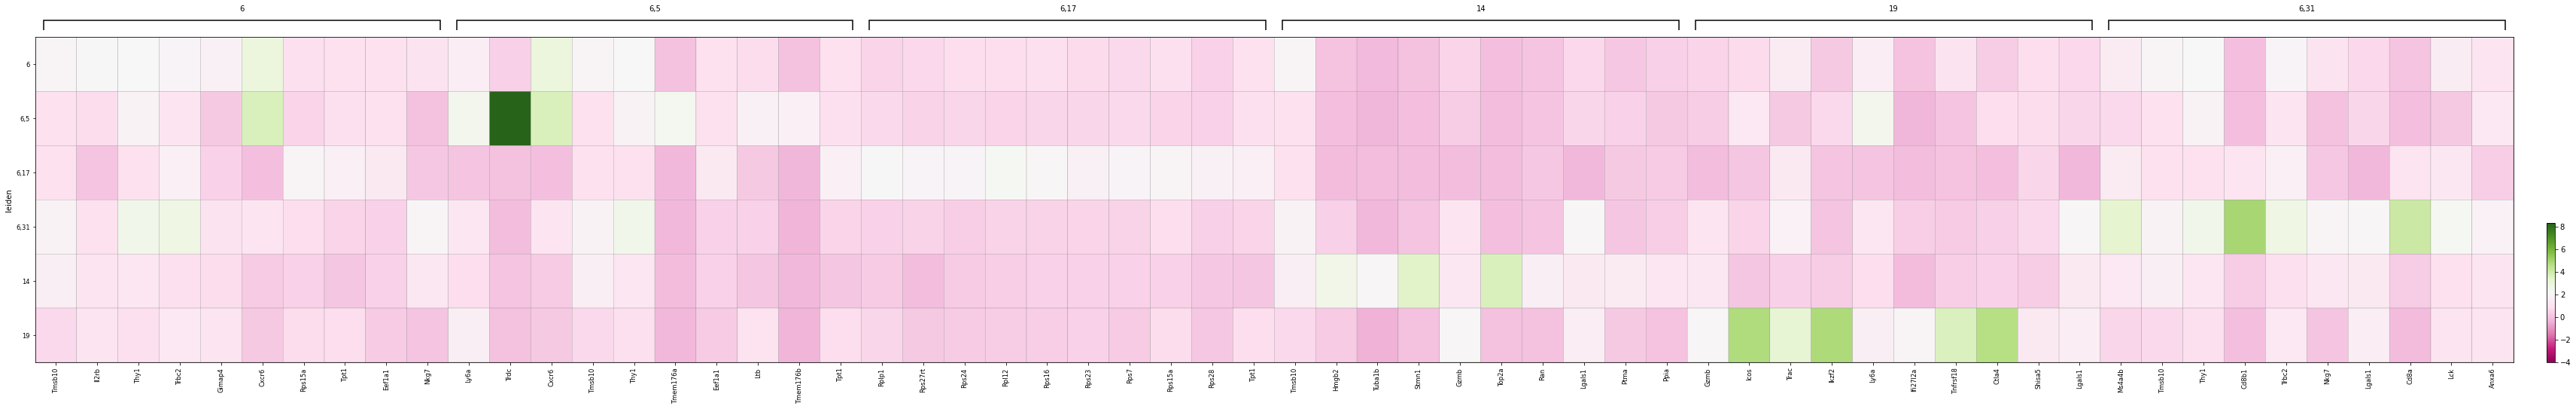

In [82]:
sc.pl.rank_genes_groups_matrixplot(adata_Z[adata_Z.obs['leiden'].isin(t_clusters)],
                                   key= 'dge_t_cells', groups = t_clusters, vmin=-4,
                                   cmap='PiYG', dendrogram=False, figsize=(60,8), n_genes=10)


In [1]:
ng.umap_plot(adata, color=['leiden', 'minor_subset', 'Nkg7', 'Ifng', 'Prf1', 'Cxcr6', 'Tnf', 'Cd3g'], save_fig = False, dpi_show=400, ncols=2)
# ng.filter_genelist("""CCR2
# CD11b
# CD16
# CD32
# CD31
# CD43
# CD44
# CD45
# CD62L""".title().split('\n'), adata)

NameError: name 'ng' is not defined

# Random forest template

In [85]:
random_subset = np.array(50*[True]+(adata.n_obs - 50)*[False])
np.random.shuffle(random_subset)
X = adata_Z[:,adata_Z.varm['highly_variable']].X
y = adata.obs.leiden.isin(['14']).astype(int)

In [86]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.5)
rf = RandomForestClassifier(random_state = 1, max_features = 10)

rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features=10,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

# Classifier performance metrics

In [87]:
y_probs_train = rf.predict_proba(X_train)[:,1]
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_probs_train)
precision_train, recall_train, _tr = precision_recall_curve(y_train, y_probs_train)
rf_f1_train = f1_score(y_train,rf.predict(X_train))

y_probs_test = rf.predict_proba(X_test)[:,1]
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_probs_test)
precision_test, recall_test, _ = precision_recall_curve(y_test, y_probs_test)
rf_f1_test = f1_score(y_test,rf.predict(X_test))


# Classifier performance

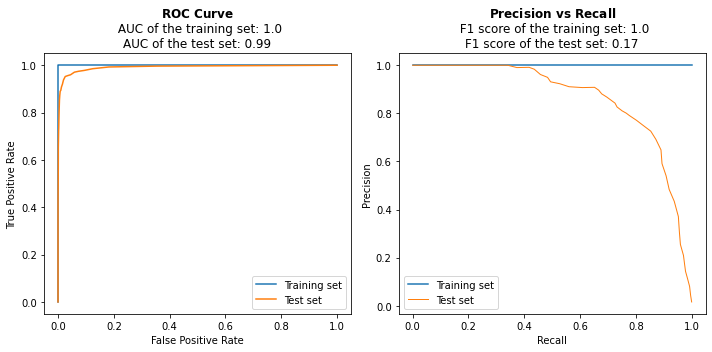

In [88]:
fig, axes = plt.subplots(1,2,figsize=(10,5))

axes[0].plot(fpr_train,tpr_train,label='Training set')
axes[0].plot(fpr_test,tpr_test,label='Test set')


axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title( r'$\bf{ROC\ Curve}$' + '\n AUC of the training set: {}\nAUC of the test set: {}'.format(round(auc(fpr_train,tpr_train),2),round(auc(fpr_test,tpr_test),2)))
axes[0].legend()

axes[1].plot(recall_train,precision_train,label='Training set')
axes[1].plot(recall_test,precision_test,label='Test set',linewidth=1)

axes[1].set_ylabel('Precision')
axes[1].set_xlabel('Recall')
axes[1].set_title( r'$\bf{Precision\ vs\ Recall}$' + '\n F1 score of the training set: {}\nF1 score of the test set: {}'.format(round(rf_f1_train,2),round(rf_f1_test,2)))
axes[1].legend()

plt.subplots_adjust(wspace=0.5,hspace=.25)
plt.tight_layout()

plt.show()

In [89]:
cluster_discriminant = {'Mono Mac Discriminant' : adata_Z[:,adata_Z.varm['highly_variable']].var.index[np.argsort(rf.feature_importances_)[-1:-10:-1]]}

In [78]:
cluster_discriminant

{'Mono Mac Discriminant': Index(['Tpt1', 'Trbc2', 'Trac', 'Eef1a1', 'Eef1b2', 'Rack1', 'Tmsb10',
        'Ms4a4b', 'Cd3d'],
       dtype='object')}

In [13]:
#rf.feature_importances_[np.argsort(rf.feature_importances_)[-1:-10:-1]]
sc.tl.rank_genes_groups(adata, groupby='leiden', key_added='group_DE_results', method = 'wilcoxon')

Trying to set attribute `.uns` of view, copying.
/home/ng136/miniconda3/envs/py36/lib/python3.6/site-packages/scanpy/tools/_rank_genes_groups.py:413: RuntimeWarning: overflow encountered in expm1
  foldchanges = (expm1_func(means[imask]) + 1e-9) / (expm1_func(mean_rest) + 1e-9)  # add small value to remove 0's


In [14]:
#adata.uns['group_DE_results']['names']
sum(adata.obs.leiden == '26')

23

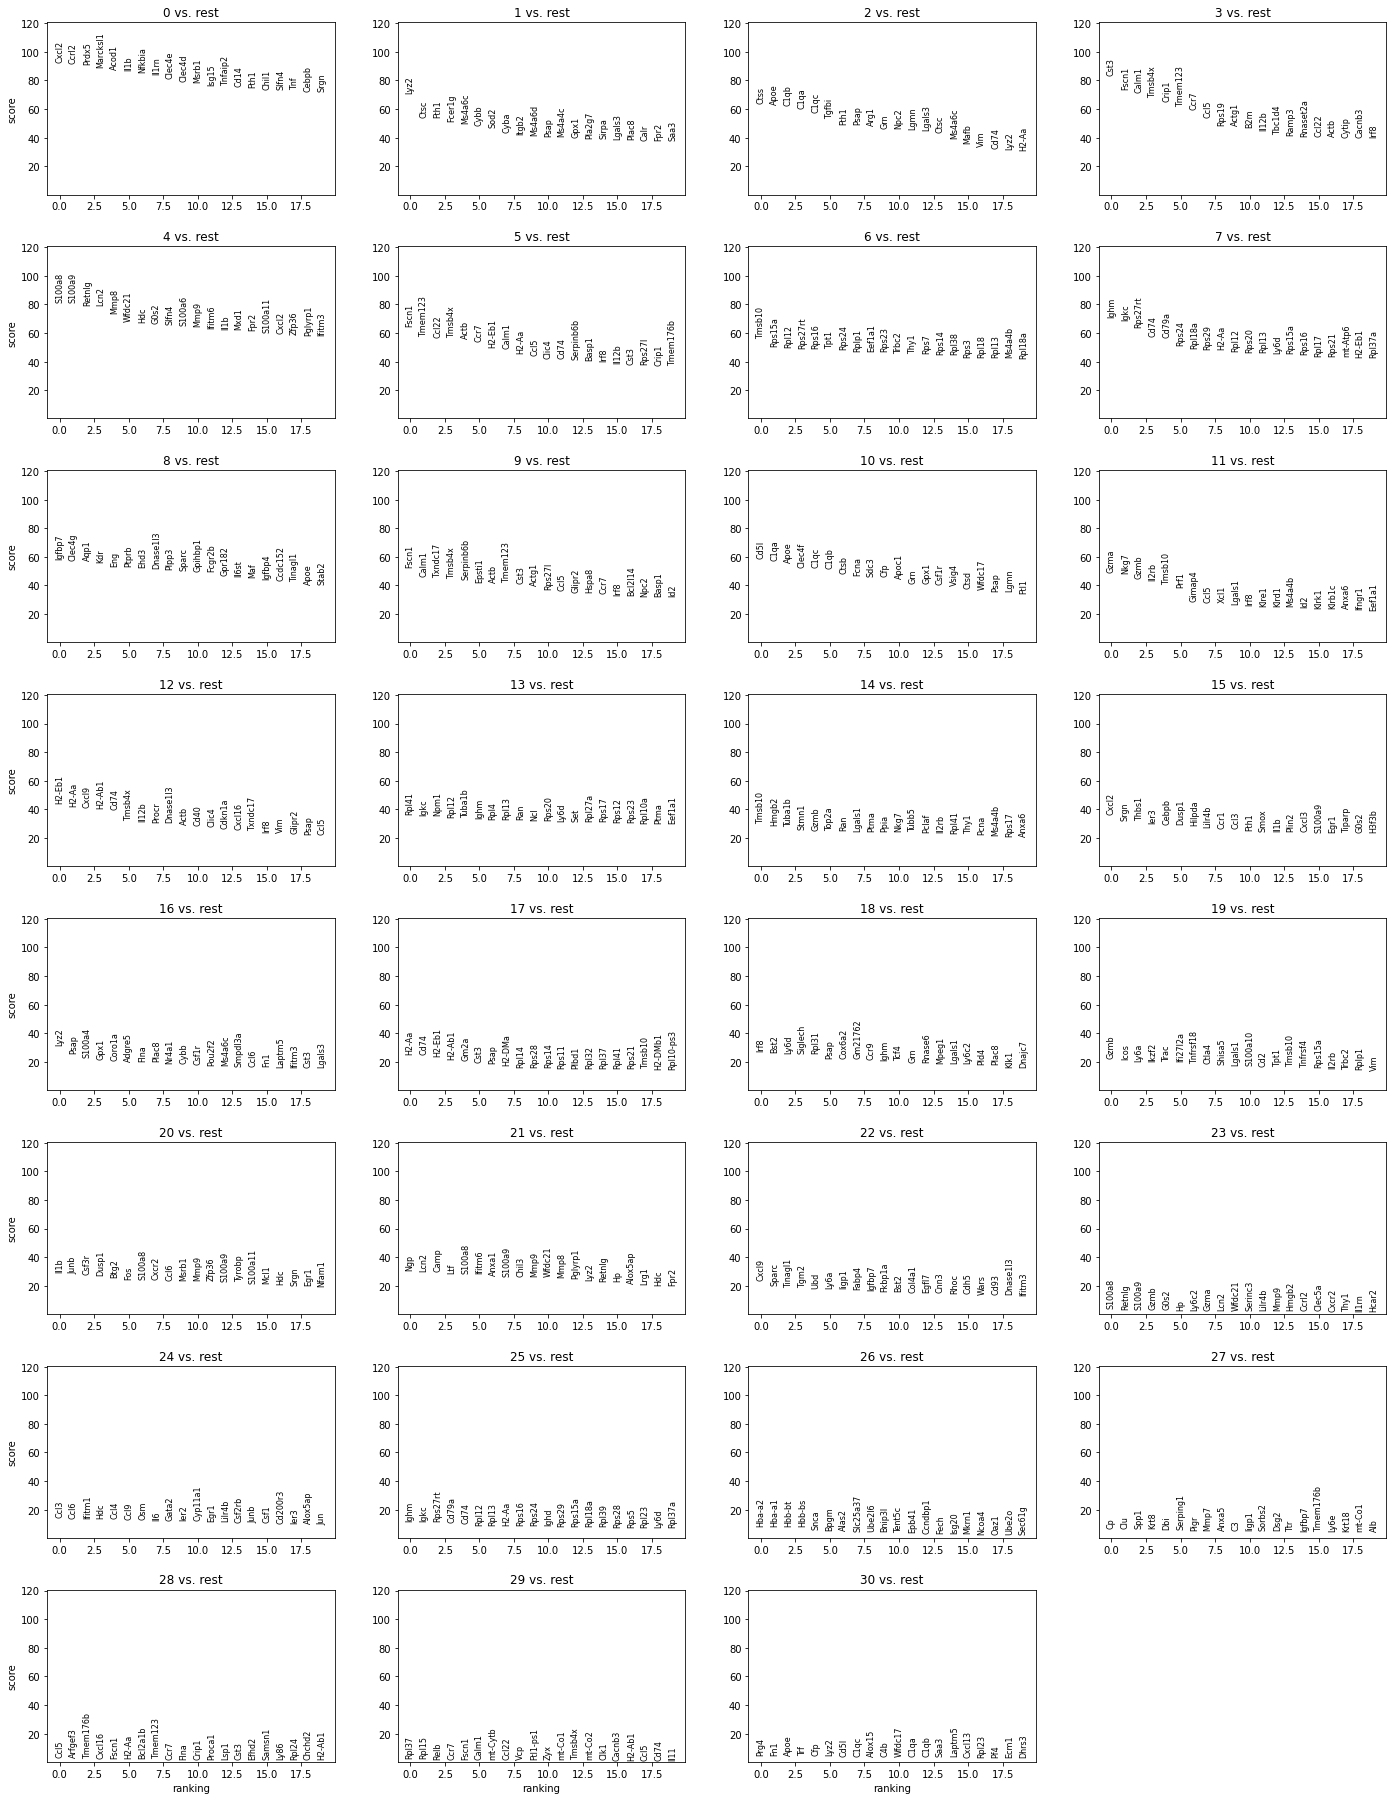

In [15]:
sc.pl.rank_genes_groups(adata, key = 'group_DE_results')

In [16]:
cluster_enrichments = [[x[i] for x in adata.uns['group_DE_results']['names']] for i in range(30)]
#adata.uns['group_DE_results']['names'][7].tolist()
#np.mean(adata.obs.query('(tissue == "Liver")&(treatment == "Trx") ')['leiden'] == '8')
#sum(adata[adata.obs.].obs['leiden'] == '8')

In [9]:
#cluster_enrichments[24]
ng.umap_plot(adata, color=['leiden', 'minor_subset'], save_fig=False, dpi_show=150)


categories: 0, 1, 2, etc.
var_group_labels: pDC, Dendritic cells, Monocytes, etc.


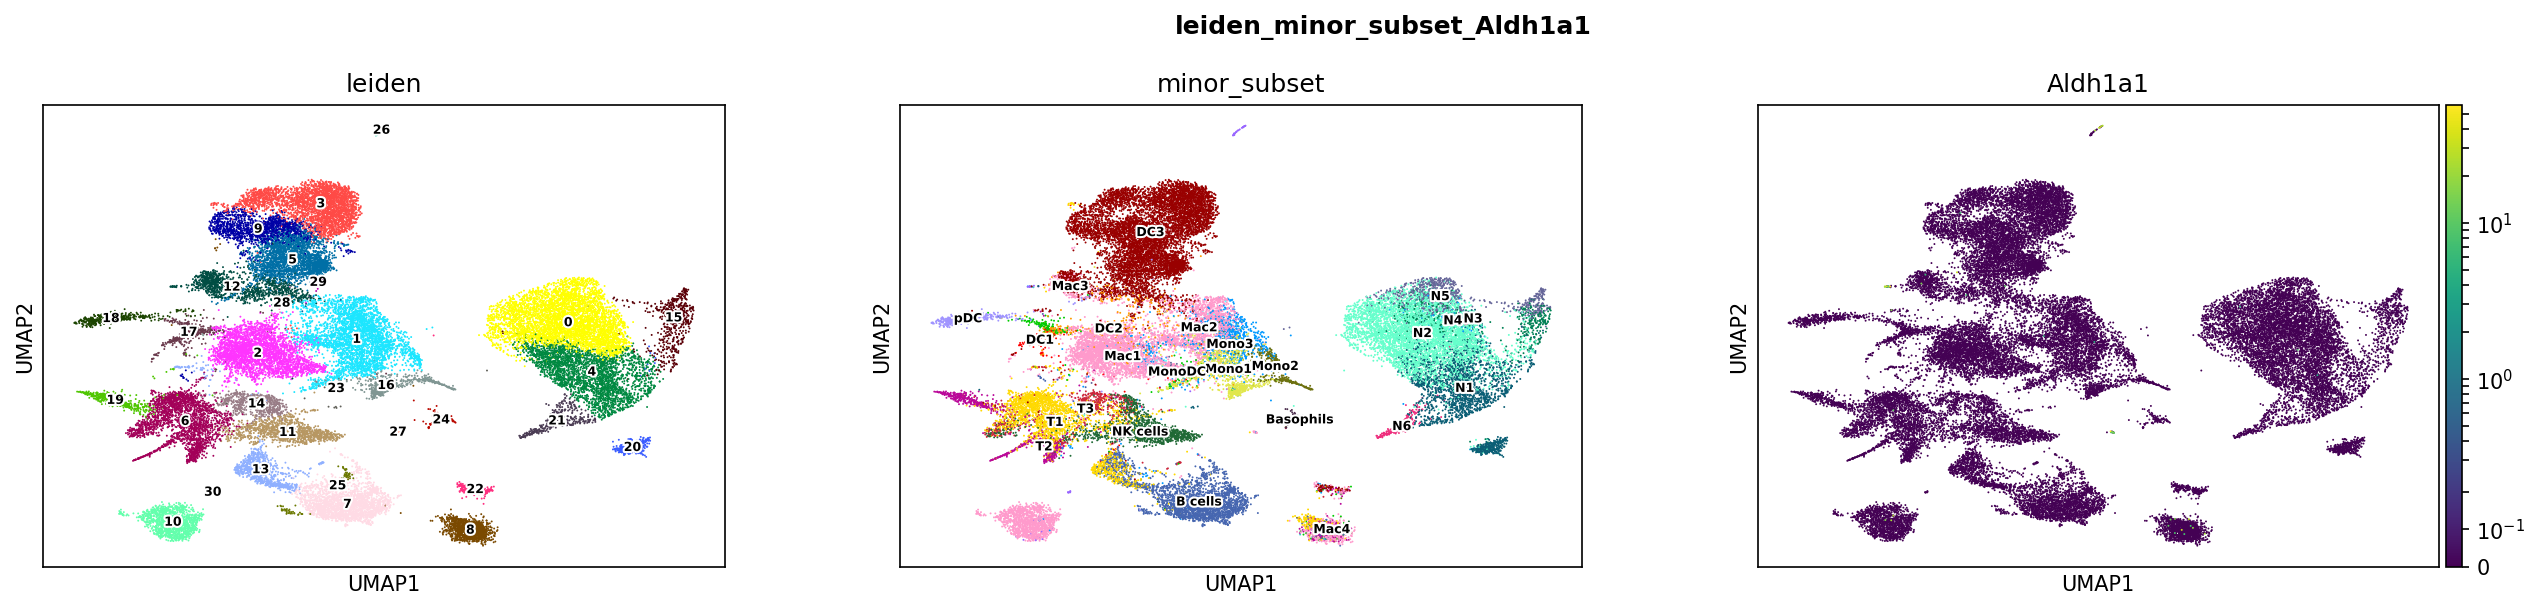

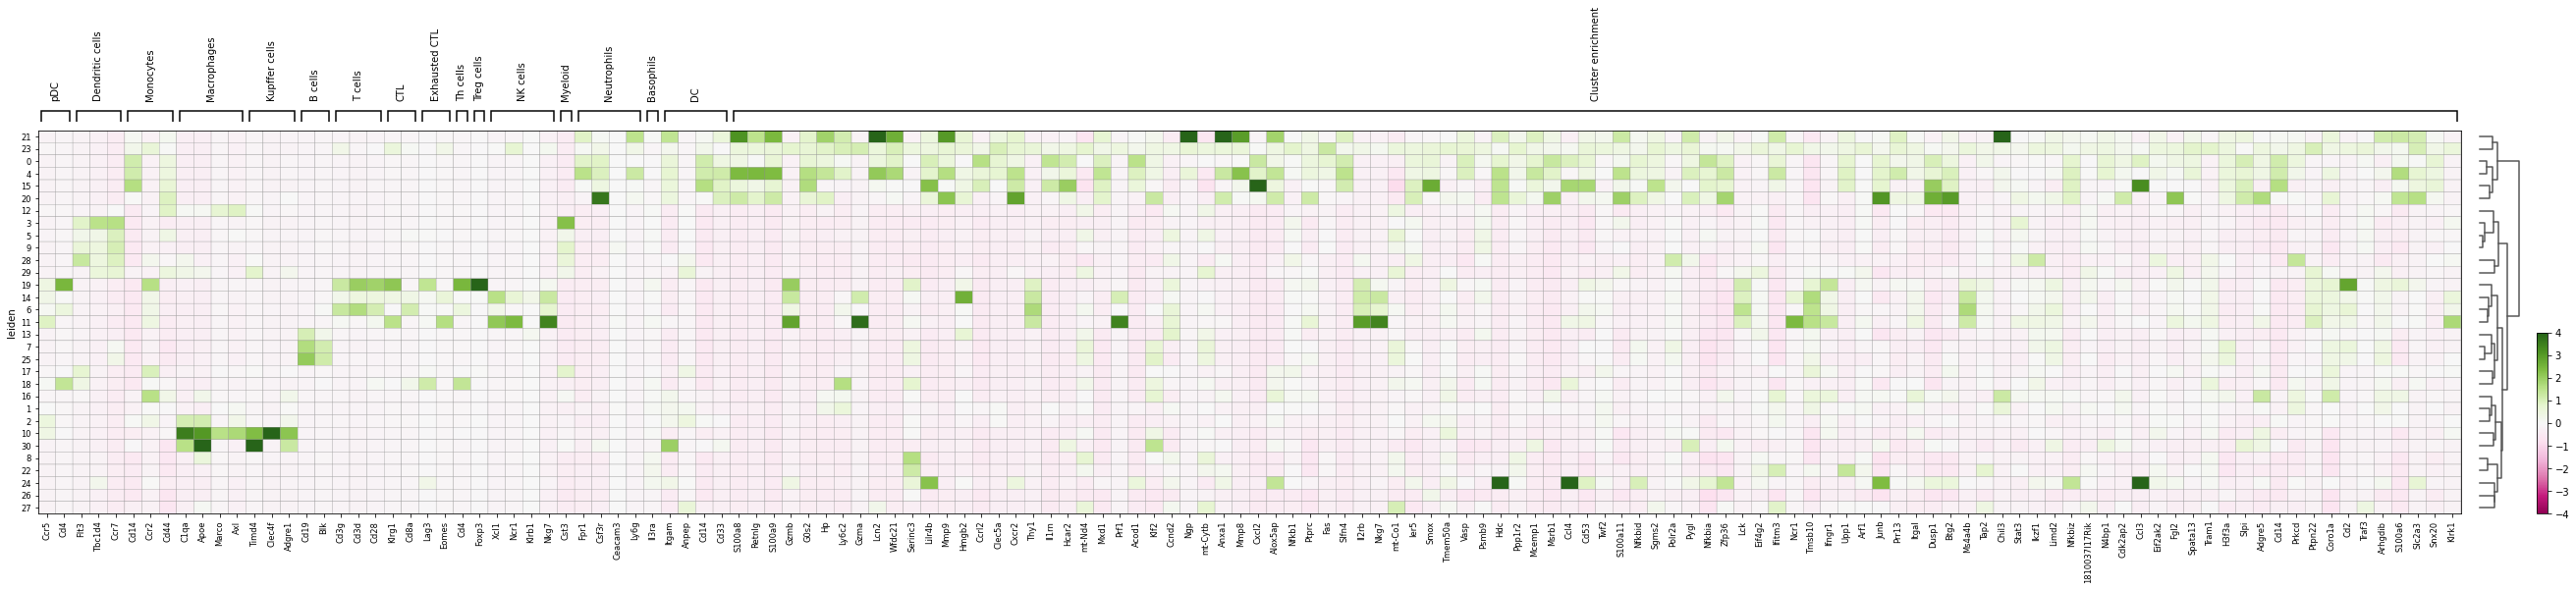

GridSpec(2, 3, height_ratios=[0.5, 10], width_ratios=[44.800000000000004, 0.8, 0.2])

In [69]:
#fig, axes = plt.subplots(1,2)
ng.umap_plot(adata, color=['leiden', 'minor_subset', 'Aldh1a1'], save_fig=False, dpi_show=150)
#plt.figure(figsize=(24,12))
#sc.pl.matrixplot(adata_Z, {**marker_gene_dict, 'DE_results': adata.uns['group_DE_results']['names'][0].tolist()}, groupby='leiden', dendrogram=True, vmin=-4, vmax = 4, cmap='PiYG')
sc.pl.matrixplot(adata_Z, {**marker_gene_dict, 'DC' : ['Itgam', 'Anpep', 'Cd14', 'Cd33'], 'Cluster enrichment' : cluster_enrichments[23]}, groupby='leiden', dendrogram=True, vmin=-4, vmax = 4, cmap='PiYG')

# np.max(adata_Z.X)

In [20]:
#print([x in adata.var_names for x in nk_genes])

!mkdir -p figures/leiden_annotation/macrophages
!mkdir -p figures/leiden_annotation/dendritic
!mkdir -p figures/leiden_annotation/kupffer
!mkdir -p figures/leiden_annotation/bcells
!mkdir -p figures/leiden_annotation/tcells
!mkdir -p figures/leiden_annotation/cd8t
!mkdir -p figures/leiden_annotation/thelper
!mkdir -p figures/leiden_annotation/nk
!mkdir -p figures/leiden_annotation/neutrophils





# Mac benchmarking

In [ ]:
start = time()
fig_mac_genes = ng.umap_plot(adata, folder='figures/leiden_annotation/macrophages', color=['cell_type', 'leiden', 'minor_subset', *marker_gene_dict['Macrophages']], return_fig=True, save_fig=True, alpha=0.5, ncols=7, split_by_cats=['tissue', 'treatment'])
print(time() - start)

# DC benchmarking

In [ ]:
start = time()
fig_dc_genes = ng.umap_plot(adata, folder='figures/leiden_annotation/dendritic', color=['cell_type', 'leiden', 'minor_subset', *marker_gene_dict['Dendritic cells']], return_fig=True, save_fig=True, alpha=0.5, ncols=7, split_by_cats=['tissue', 'treatment'])
print(time() - start)

# KC benchmarking

In [ ]:
start = time()
fig_kc_genes = ng.umap_plot(adata, folder='figures/leiden_annotation/kupffer', color=['cell_type', 'leiden', 'minor_subset', *marker_gene_dict['Kupffer cells']], return_fig=True, save_fig=True, alpha=0.5, ncols=7, split_by_cats=['tissue', 'treatment'])
print(time() - start)

# B cell benchmarking

In [ ]:
start = time()
fig_bc_genes = ng.umap_plot(adata, folder='figures/leiden_annotation/bcells', color=['cell_type', 'leiden', 'minor_subset', *marker_gene_dict['B cells']], return_fig=True, save_fig=True, alpha=0.5, ncols=7, split_by_cats=['tissue', 'treatment'])
print(time() - start)

# T cell benchmarking

In [ ]:
start = time()
fig_tc_genes = ng.umap_plot(adata, folder='figures/leiden_annotation/tcells', color=['cell_type', 'leiden', 'minor_subset', *marker_gene_dict['T cells']], return_fig=True, save_fig=True, alpha=0.5, ncols=7, split_by_cats=['tissue', 'treatment'])
print(time() - start)

# Cytotoxic T cell benchmarking

In [ ]:
start = time()
fig_cd8t_genes = ng.umap_plot(adata, folder='figures/leiden_annotation/cd8t', color=['cell_type', 'leiden', 'minor_subset', *marker_gene_dict['CTL']], return_fig=True, save_fig=True, alpha=0.5, ncols=7, split_by_cats=['tissue', 'treatment'])
print(time() - start)

# T helper cell benchmarking

Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.


figures/leiden_annotation/thelper/tissue_Liver_treatment_Trx_by_cell_type_leiden_minor_subset_Cd4_200417_02h46_1.pdf done!


Trying to set attribute `.uns` of view, copying.


figures/leiden_annotation/thelper/tissue_Tumor_treatment_NT_by_cell_type_leiden_minor_subset_Cd4_200417_02h46_2.pdf done!


Trying to set attribute `.uns` of view, copying.


figures/leiden_annotation/thelper/tissue_Liver_treatment_NT_by_cell_type_leiden_minor_subset_Cd4_200417_02h46_3.pdf done!
figures/leiden_annotation/thelper/tissue_Tumor_treatment_Trx_by_cell_type_leiden_minor_subset_Cd4_200417_02h46_4.pdf done!
18.99437189102173


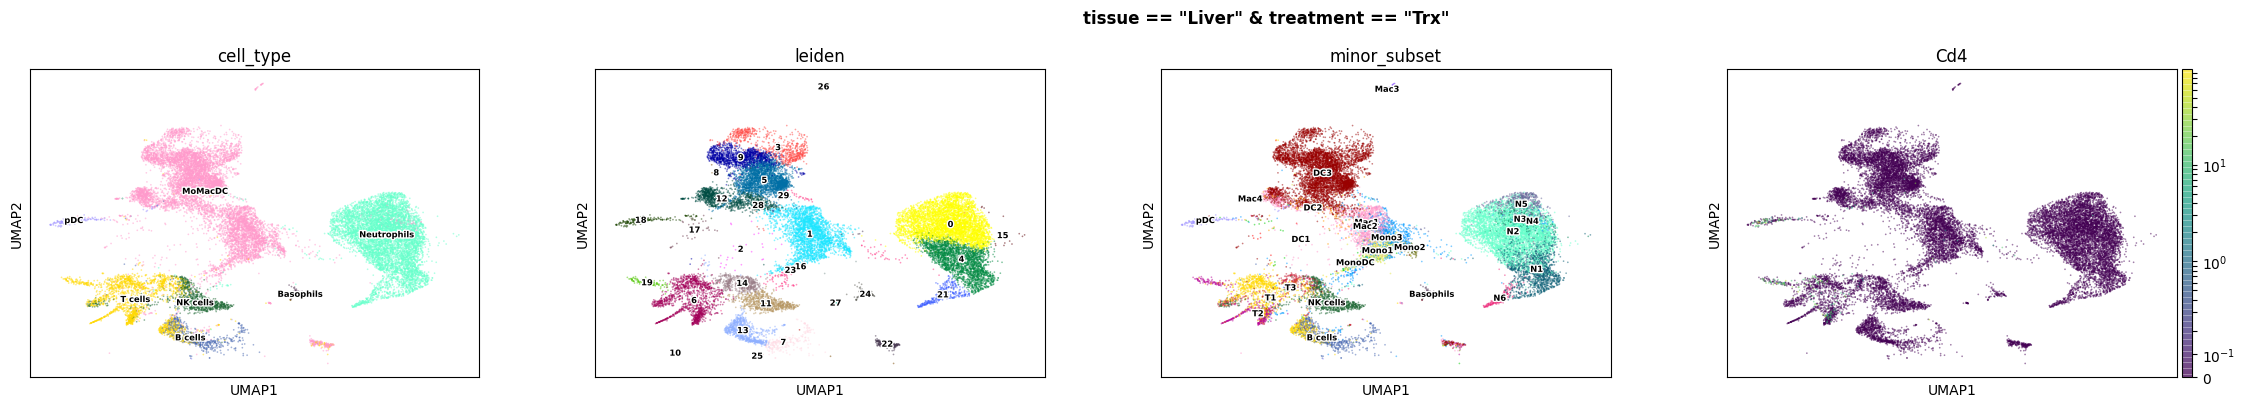

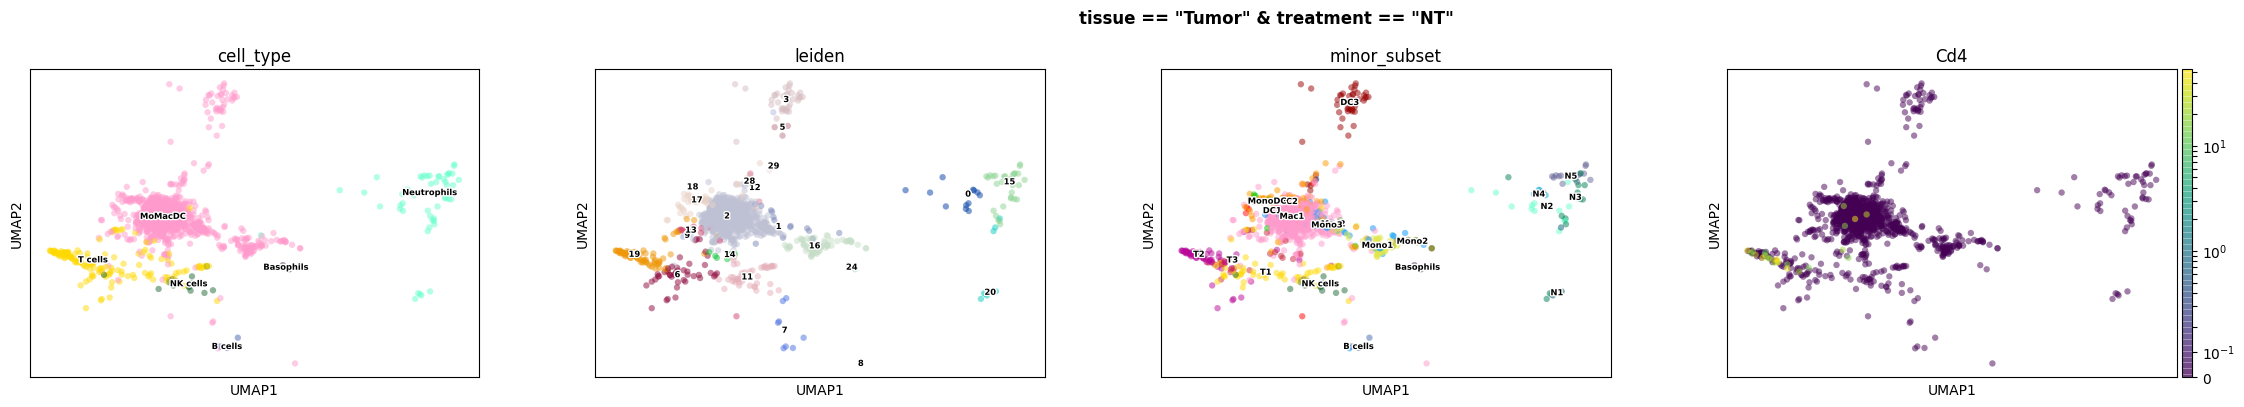

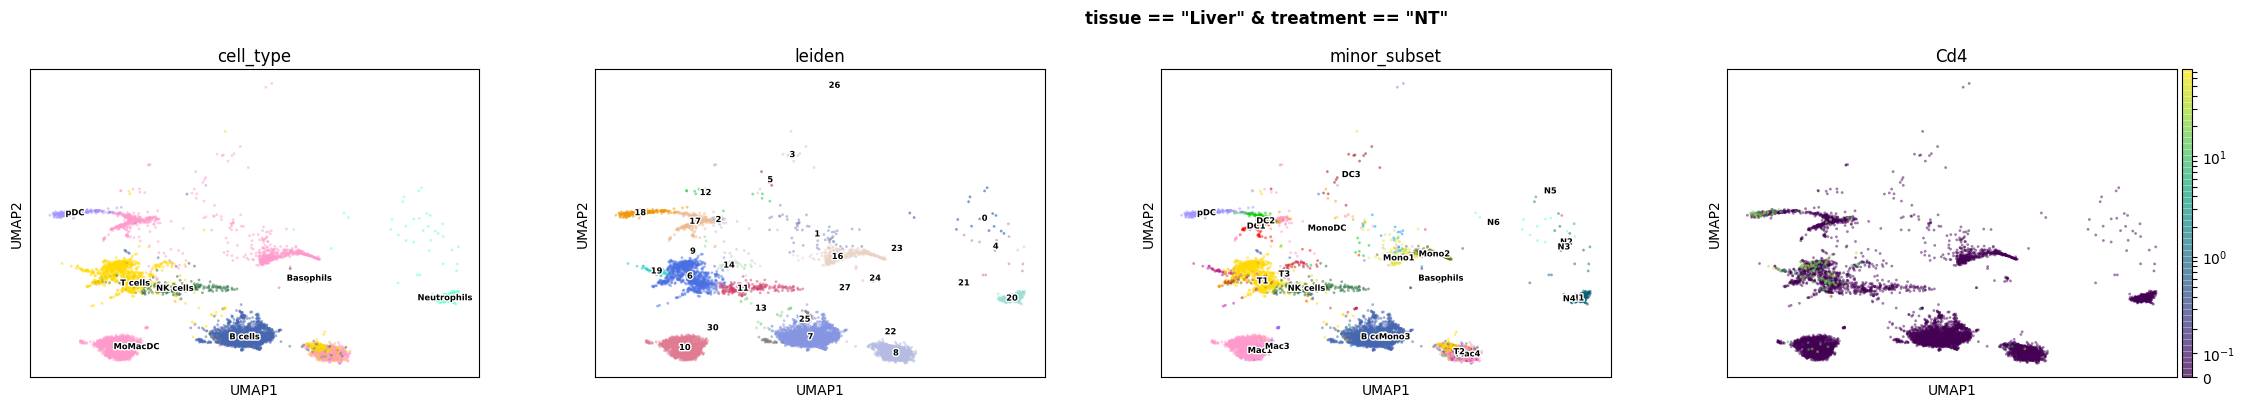

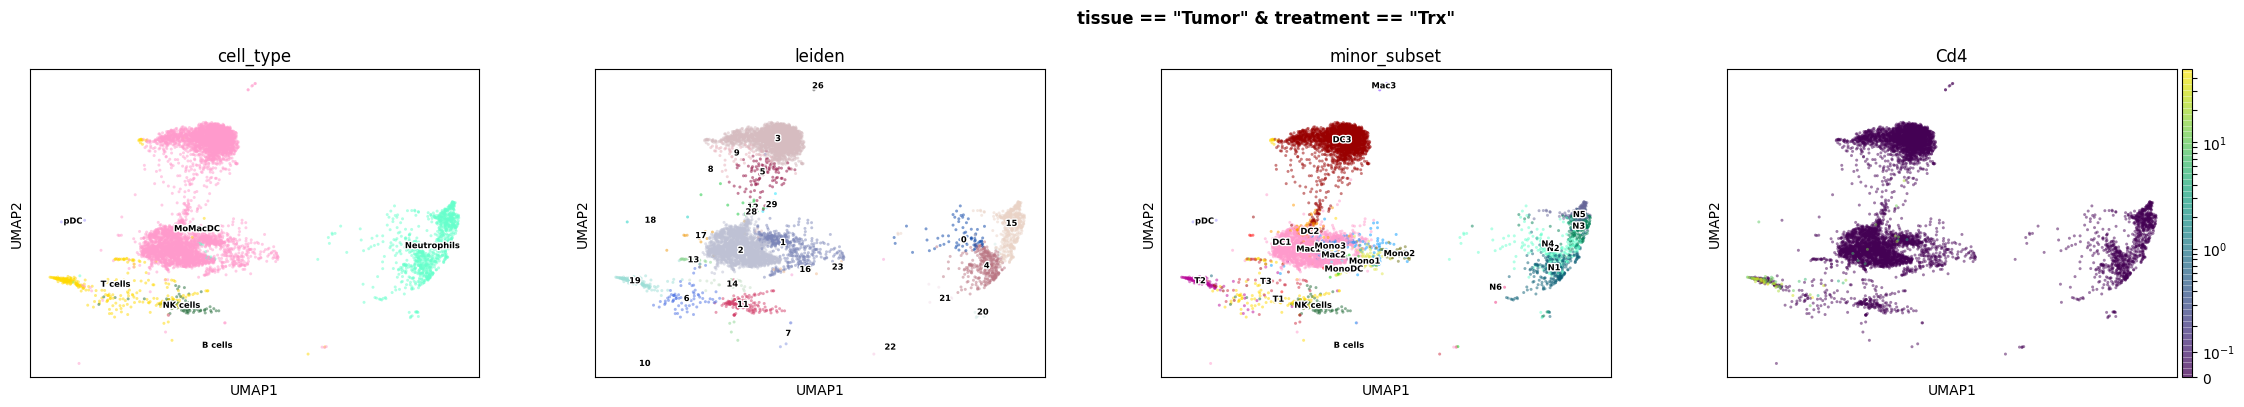

In [18]:
start = time()
fig_th_genes = ng.umap_plot(adata, folder='figures/leiden_annotation/thelper', color=['cell_type', 'leiden', 'minor_subset', *marker_gene_dict['Th cells']], return_fig=True, save_fig=True, alpha=0.5, ncols=7, split_by_cats=['tissue', 'treatment'])
print(time() - start)

# NK cell benchmarking

figures/leiden_annotation/nk/tissue_Liver_treatment_NT_by_cell_type_leiden_minor_subset_Xcl1_Ncr1_Klrb1_Nkg7_200426_01h52_1.pdf done!
figures/leiden_annotation/nk/tissue_Liver_treatment_Trx_by_cell_type_leiden_minor_subset_Xcl1_Ncr1_Klrb1_Nkg7_200426_01h52_2.pdf done!
figures/leiden_annotation/nk/tissue_Tumor_treatment_NT_by_cell_type_leiden_minor_subset_Xcl1_Ncr1_Klrb1_Nkg7_200426_01h53_3.pdf done!
figures/leiden_annotation/nk/tissue_Tumor_treatment_Trx_by_cell_type_leiden_minor_subset_Xcl1_Ncr1_Klrb1_Nkg7_200426_01h53_4.pdf done!
27.552661657333374


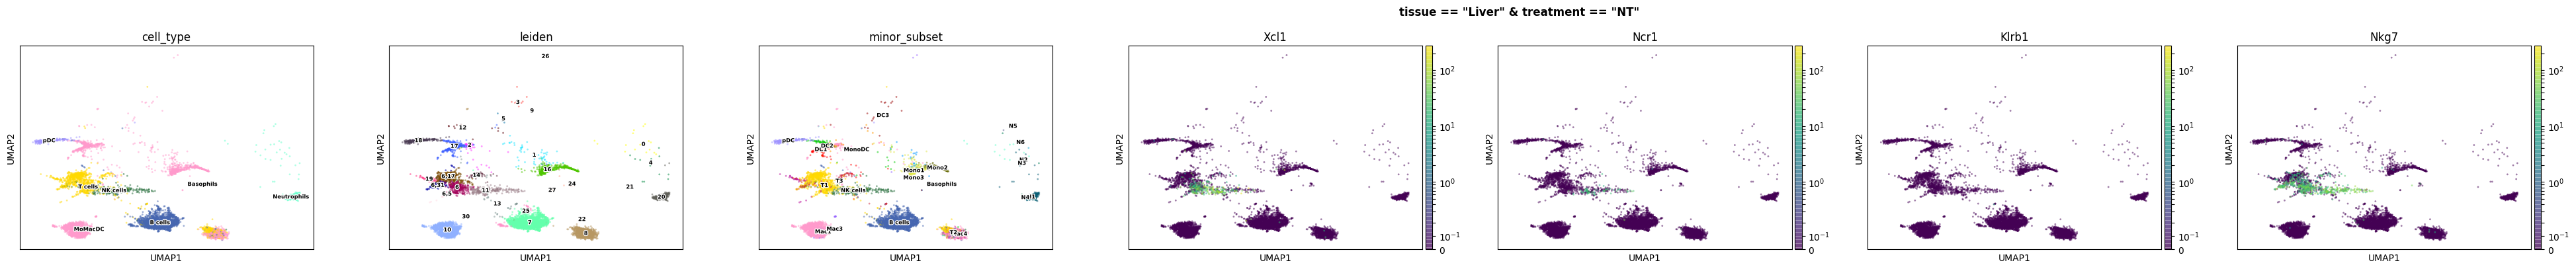

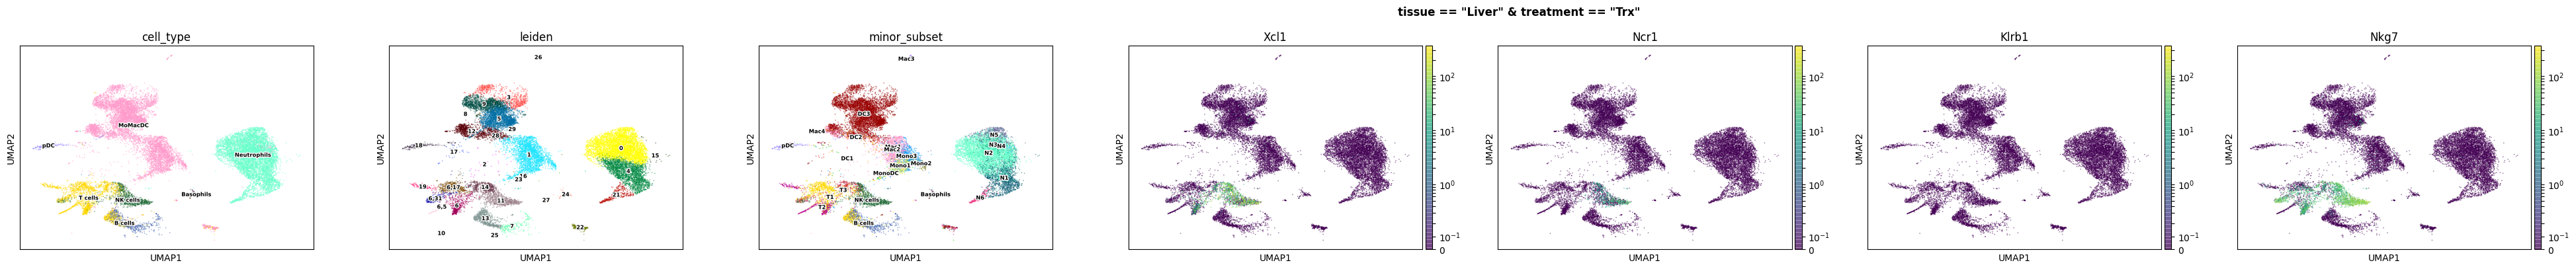

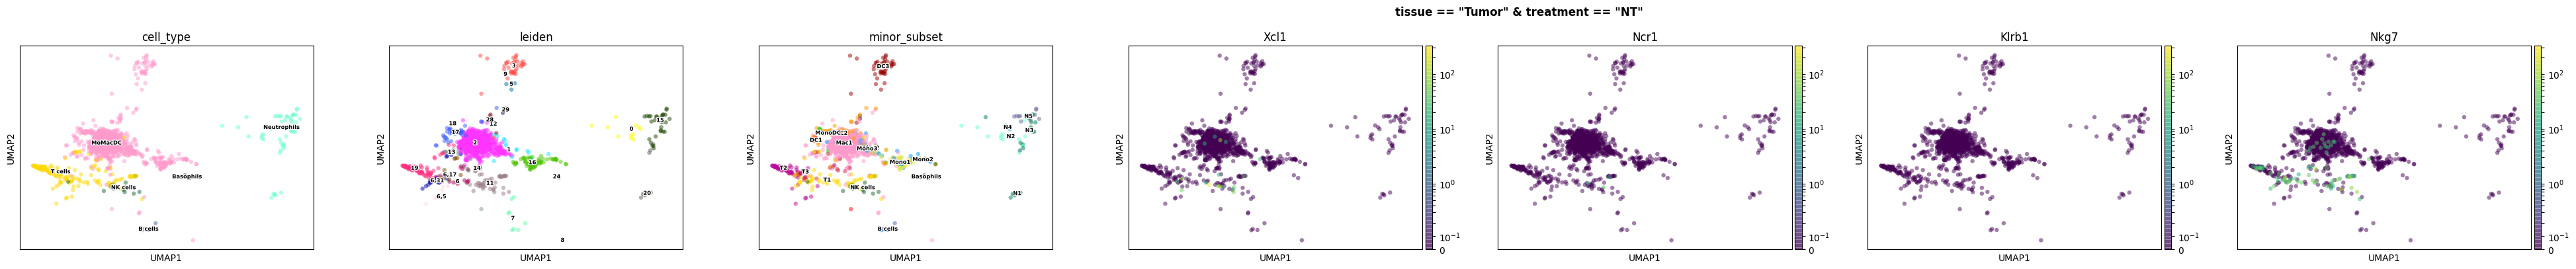

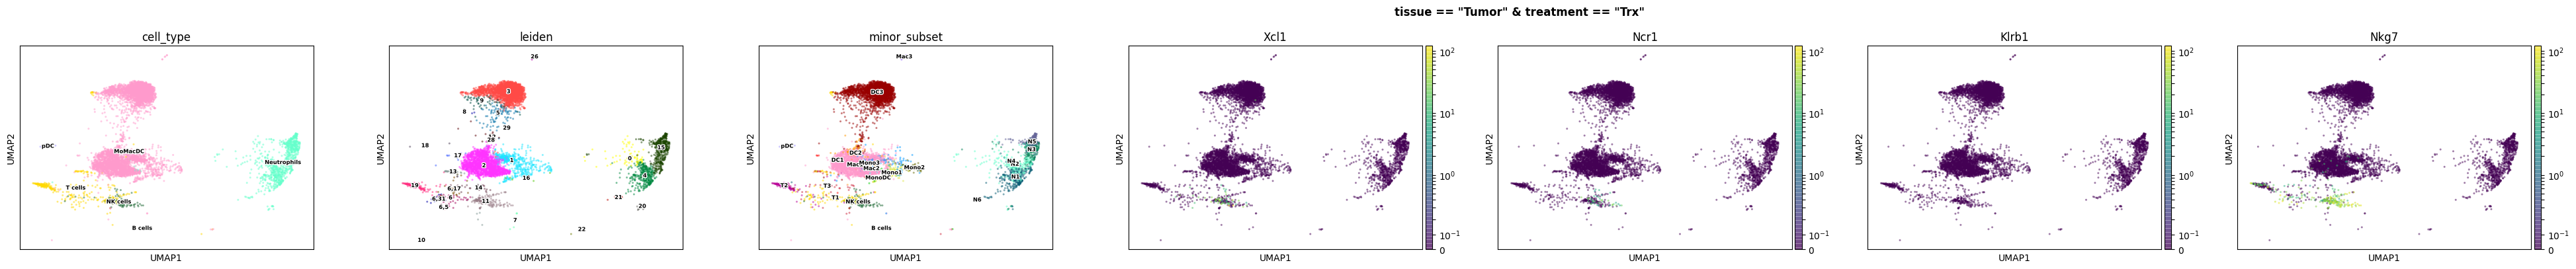

In [90]:
start = time()
fig_nk_genes = ng.umap_plot(adata, folder='figures/leiden_annotation/nk', color=['cell_type', 'leiden', 'minor_subset', *marker_gene_dict['NK cells']], return_fig=True, save_fig=True, alpha=0.5, ncols=7, split_by_cats=['tissue', 'treatment'])
print(time() - start)

# Neutrophils benchmarking

Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.


figures/leiden_annotation/neutrophils/tissue_Liver_treatment_NT_by_cell_type_leiden_minor_subset_Fpr1_Csf3r_Ceacam3_Ly6g_200417_20h01_1.pdf done!


Trying to set attribute `.uns` of view, copying.


figures/leiden_annotation/neutrophils/tissue_Liver_treatment_Trx_by_cell_type_leiden_minor_subset_Fpr1_Csf3r_Ceacam3_Ly6g_200417_20h01_2.pdf done!


Trying to set attribute `.uns` of view, copying.


figures/leiden_annotation/neutrophils/tissue_Tumor_treatment_NT_by_cell_type_leiden_minor_subset_Fpr1_Csf3r_Ceacam3_Ly6g_200417_20h01_3.pdf done!
figures/leiden_annotation/neutrophils/tissue_Tumor_treatment_Trx_by_cell_type_leiden_minor_subset_Fpr1_Csf3r_Ceacam3_Ly6g_200417_20h02_4.pdf done!
33.27552127838135


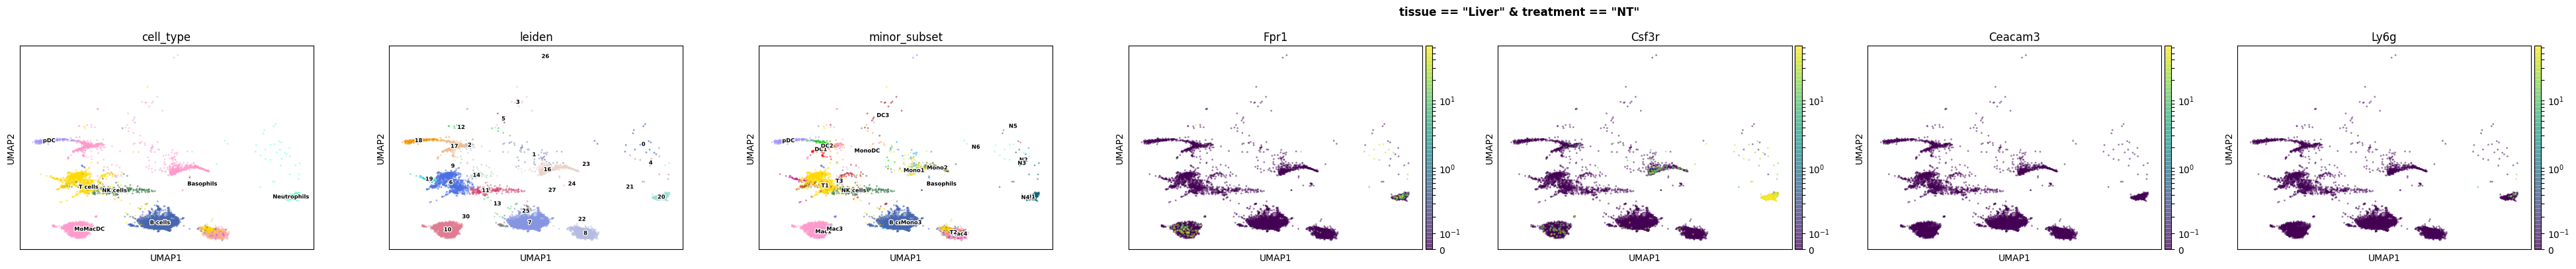

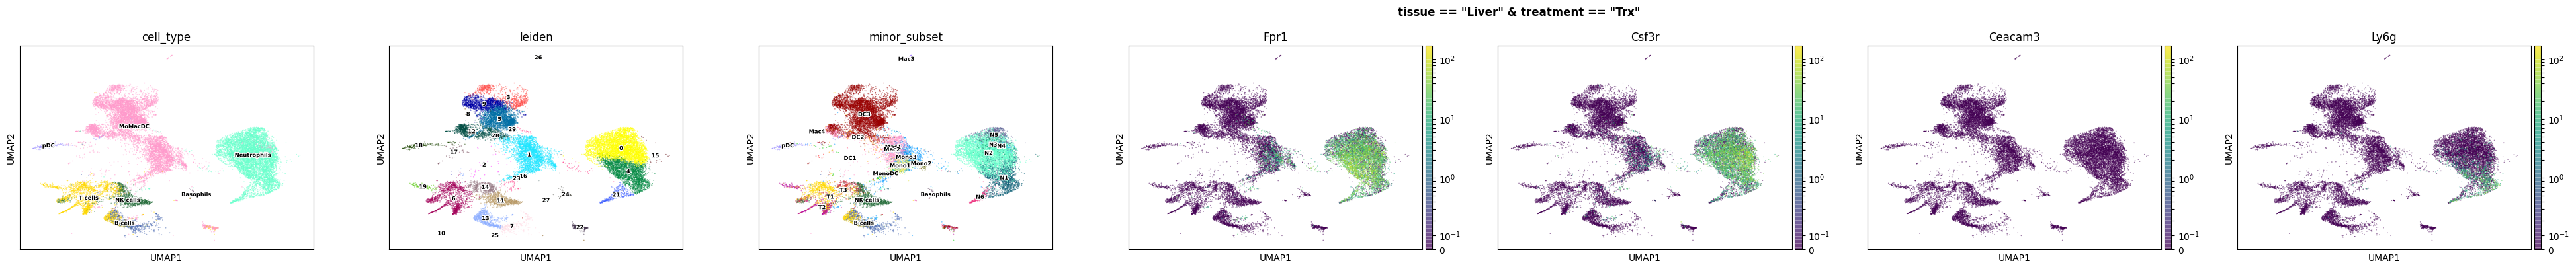

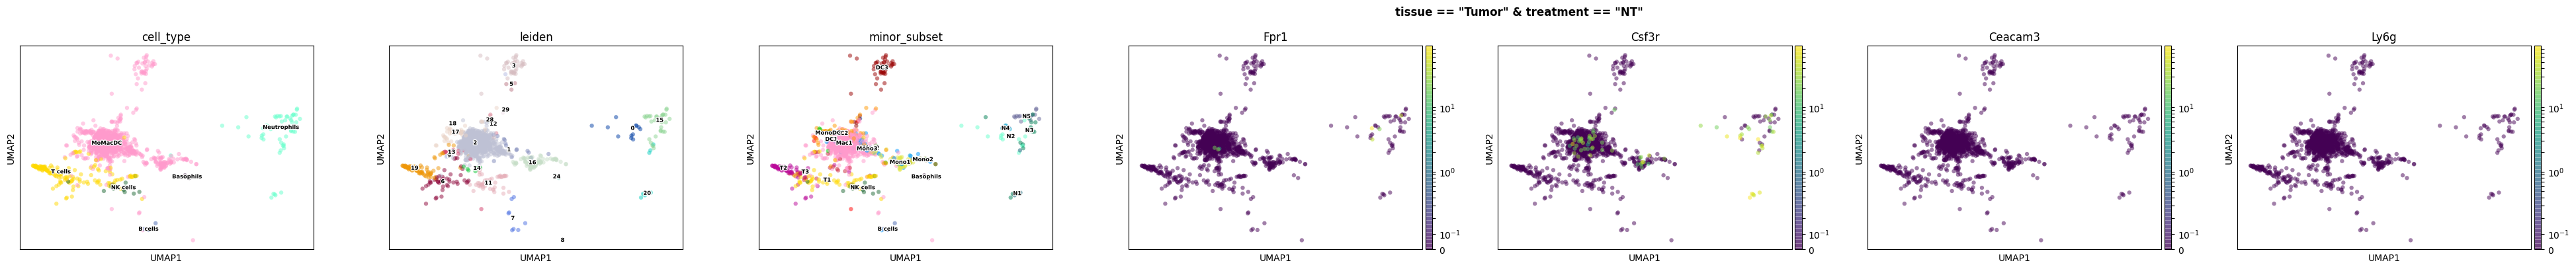

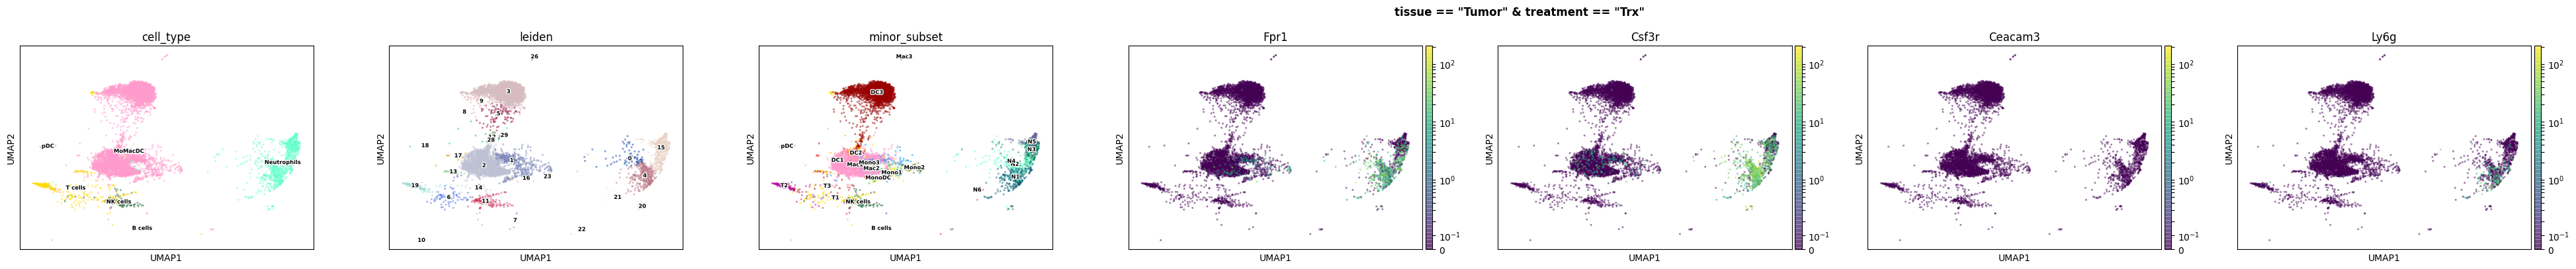

In [25]:
start = time()
fig_neu_genes = ng.umap_plot(adata, folder='figures/leiden_annotation/neutrophils', color=['cell_type', 'leiden', 'minor_subset', *marker_gene_dict['Neutrophils']], return_fig=True, save_fig=True, alpha=0.5, ncols=7, split_by_cats=['tissue', 'treatment'])
print(time() - start)

# T cell benchmarking

In [ ]:
start = time()
fig_tc_genes = ng.umap_plot(adata, folder='figures/leiden_annotation/tc', color=['cell_type', 'leiden', 'minor_subset', *tc_genes], return_fig=True, save_fig=True, alpha=0.5, ncols=7, split_by_cats=['tissue', 'treatment'])
print(time() - start)

In [ ]:
ng.umap_plot(adata, folder='figures/leiden_annotation', color=['Il12b', 'Batf3', 'leiden'], return_fig=True, save_fig=False, alpha=0.5, ncols=3, split_by_cats=['tissue', 'treatment'])


In [ ]:
ng.umap_plot(adata, folder='figures/leiden_annotation', color=['minor_subset', 'leiden', 'Cd19'], return_fig=True, save_fig=False, alpha=0.5, ncols=4, split_by_cats=['tissue', 'treatment'])


In [ ]:
'Cd3a' in adata.var_names

Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.


[<Figure size 2061x400 with 4 Axes>,
 <Figure size 2061x400 with 4 Axes>,
 <Figure size 2061x400 with 4 Axes>,
 <Figure size 2061x400 with 4 Axes>]

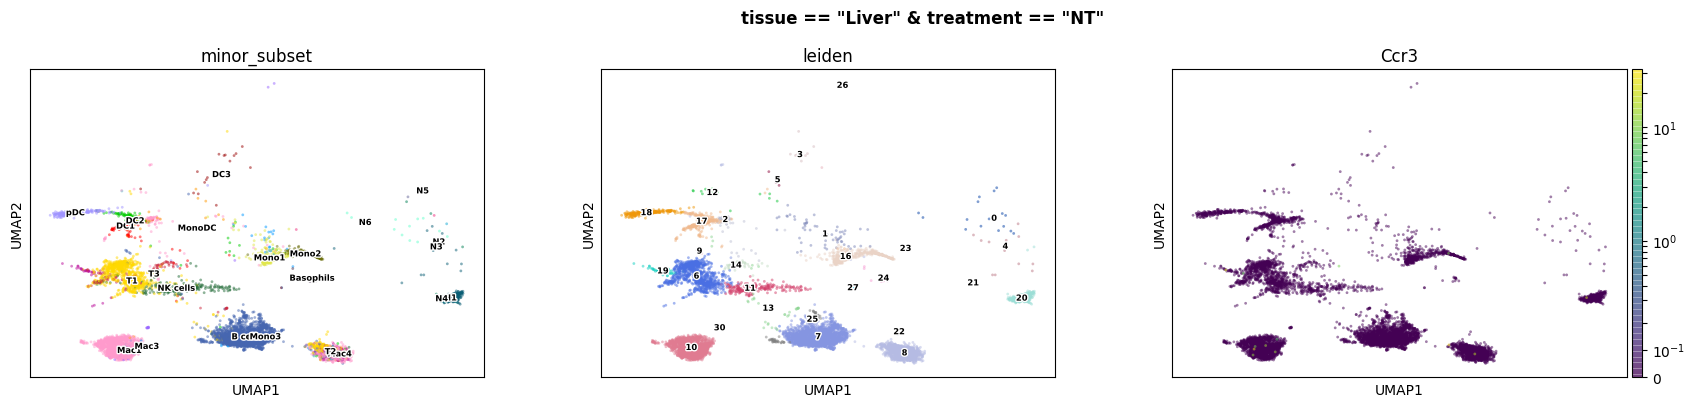

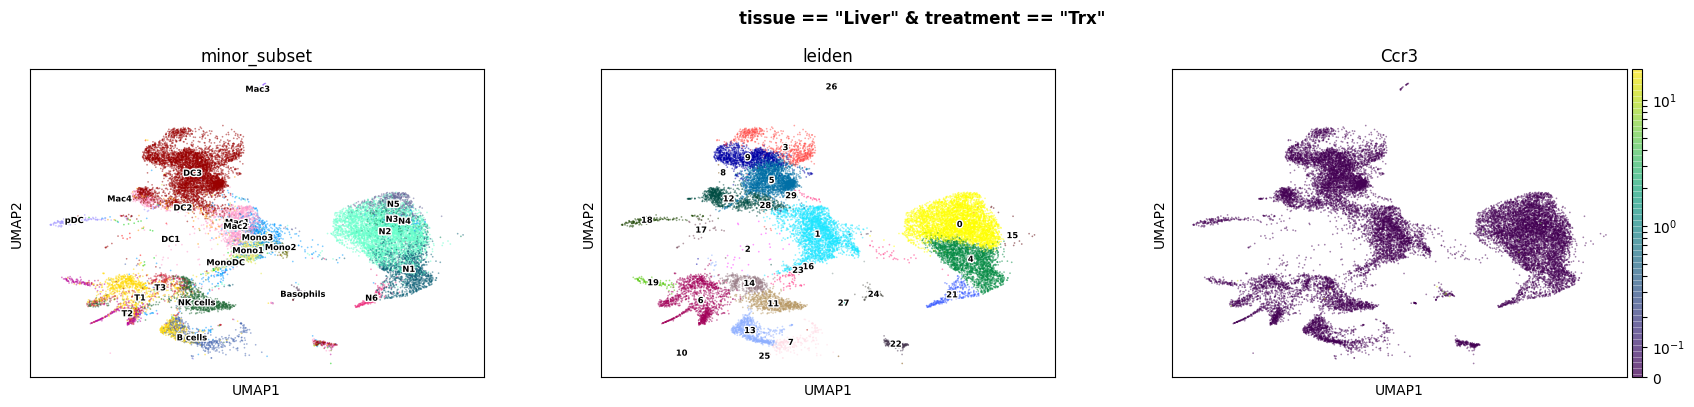

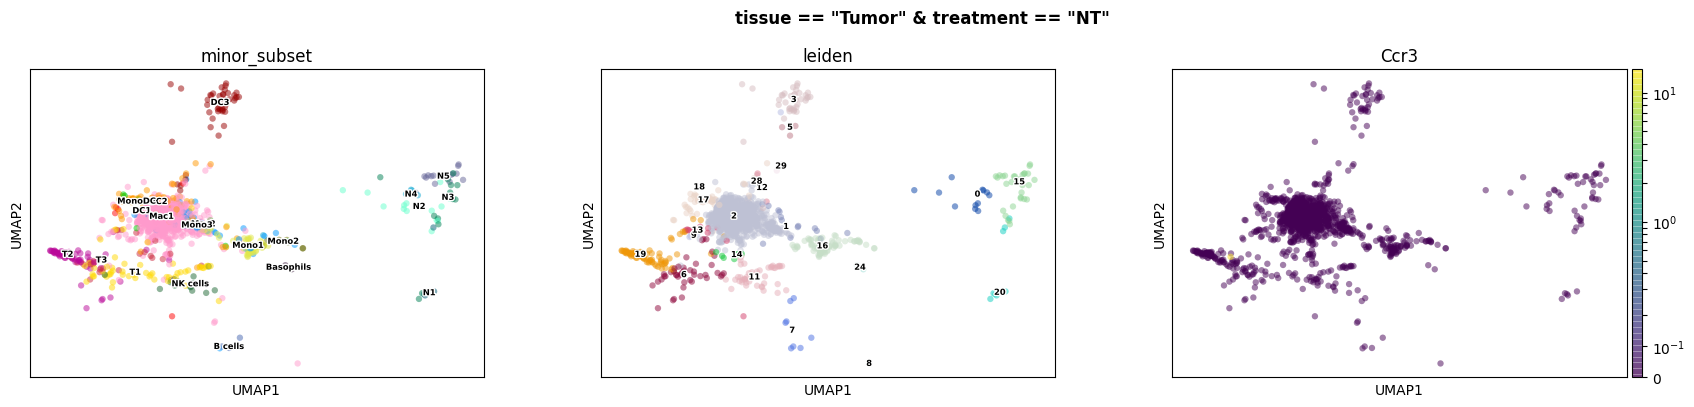

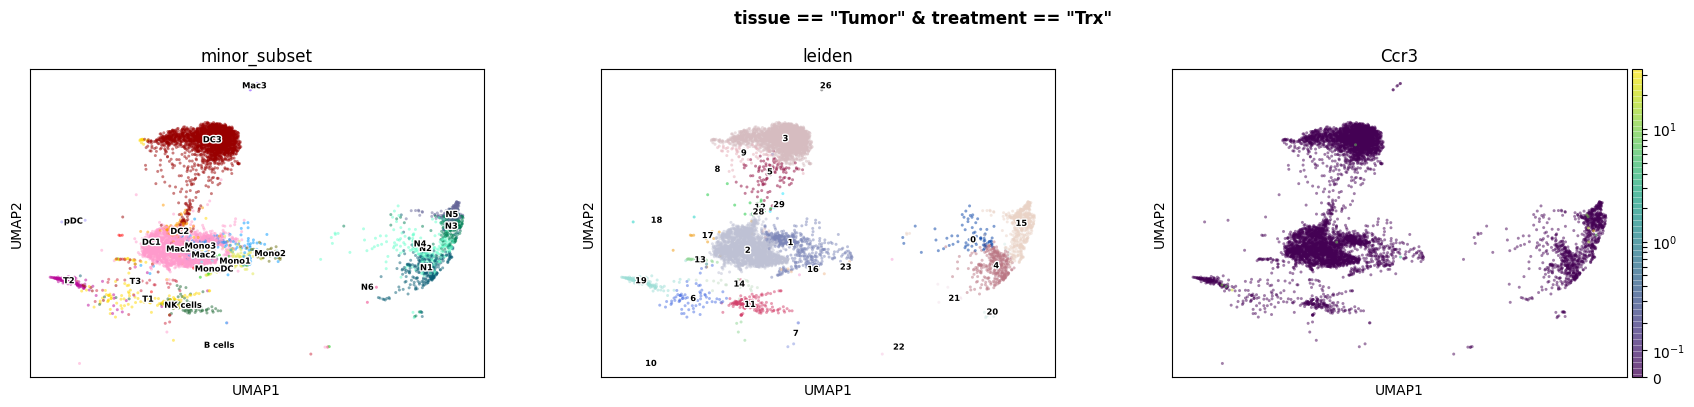

In [32]:
ng.umap_plot(adata, folder='figures/leiden_annotation', color=['minor_subset', 'leiden', 'Ccr3'], return_fig=True, save_fig=False, alpha=0.5, ncols=4, split_by_cats=['tissue', 'treatment'])
 